<a href="https://colab.research.google.com/github/Madalina0303/integrated-recovery-room-planning-and-scheduling/blob/main/Nurse_Scheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pulp

In [10]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import table
import os, sys, json
from pulp import *

%matplotlib inline

In [11]:
shifts = [0, 1, 2] # 3 sfifturi pe zi

# Label the days from Monday to Sunday. 
days = ['M', 'Tu', 'W', 'Th', 'F','Sa','Su']

require_nurses = pd.DataFrame(data = None, columns=days, index = shifts)
s0_nurse, s1_nurse, s2_nurse = 5, 4, 3 #nr de asistente necesare pe fiecare shift

for j in range(0, 7):
    require_nurses.iloc[0][j] = s0_nurse
    require_nurses.iloc[1][j] = s1_nurse
    require_nurses.iloc[2][j] = s2_nurse

# List of number of nurses required in specific shift s

# r[even index]: required nurses in day shift
# r[odd index]: required nurses in night shift
r = require_nurses.values.swapaxes(0,1).ravel()

print("The number of nurses required for each shift is:" )
print(r)

print("\nIn matrix form:")
print(require_nurses.head())


# Total number of the nurses, at least more than sum(r)/3. Here use sum(r)/2.5
total = int(sum(r)/2.5)
print("\nTotal number of nurses are: {}".format(total))

# Create nurses_id tag
nurses_id = ['nurse'+str(i) for i in range(total)]
print("\nThe nurses are: ")
print(nurses_id)

The number of nurses required for each shift is:
[5 4 3 5 4 3 5 4 3 5 4 3 5 4 3 5 4 3 5 4 3]

In matrix form:
   M Tu  W Th  F Sa Su
0  5  5  5  5  5  5  5
1  4  4  4  4  4  4  4
2  3  3  3  3  3  3  3

Total number of nurses are: 33

The nurses are: 
['nurse0', 'nurse1', 'nurse2', 'nurse3', 'nurse4', 'nurse5', 'nurse6', 'nurse7', 'nurse8', 'nurse9', 'nurse10', 'nurse11', 'nurse12', 'nurse13', 'nurse14', 'nurse15', 'nurse16', 'nurse17', 'nurse18', 'nurse19', 'nurse20', 'nurse21', 'nurse22', 'nurse23', 'nurse24', 'nurse25', 'nurse26', 'nurse27', 'nurse28', 'nurse29', 'nurse30', 'nurse31', 'nurse32']


In [6]:
with open('/content/drive/MyDrive/day_off.json', 'r') as fp:
    off_shift = json.load(fp)
    
print(off_shift)

{'0': [1], '2': [0], '3': [12, 10], '4': [7, 13], '5': [1], '10': [3], '15': [2]}


In [14]:
'''
shifts: label each shift. For example: Monday day shift is 0, Monday second shift is 1, Monday night shift is 2, etc.
'''

## Create shift names based on index:
shift_name = []
for s in range(len(shifts)*len(days)):
    # find the day shift or night shift
    if s%3 == 0:
      ss = 's1'
    elif s%3 == 1:
      ss = 's2'
    else:
      ss = 's3'
    shift_name.append(days[s//3] + '_' + ss)
    
print("\nThe names of corresponding shifts are: ")
print(shift_name)



The names of corresponding shifts are: 
['M_s1', 'M_s2', 'M_s3', 'Tu_s1', 'Tu_s2', 'Tu_s3', 'W_s1', 'W_s2', 'W_s3', 'Th_s1', 'Th_s2', 'Th_s3', 'F_s1', 'F_s2', 'F_s3', 'Sa_s1', 'Sa_s2', 'Sa_s3', 'Su_s1', 'Su_s2', 'Su_s3']


In [34]:
def LpProb():

    '''
    Use pulp to solve the constrained problem using linear programming(LP) algorithm. 
    1. Start the instance of a LpProblem: pulp.LpProblem(name_str, sense = 'LpMaxmize' or 'LpMinimize')
    2. Create LpVariables. Binary category in this case
    3. Add constraints in either equality or inequality conditions.
    4. Building objective using LpObjective. 
    5. Use Solver to solve the problem, display the status and optimized values.
    '''

    # The prob variable is created to contain the problem data   
    prob = LpProblem("Nurse scheduling",LpMinimize)
    
    # Creating the variables. 
    var = {
     (n, s): pulp.LpVariable(
        "schdule_{0}_{1}".format(n, s), cat = "Binary")
        for n in range(total) for s in range(len(days)*len(shifts))

    }
    # add constraints: 
    # Nurses do not work in two consecutive shifts
    # If nurse works for a night shift, he/she will take a next day off

    for n in range(total):
        for s in range(len(days)*len(shifts)):
            if s%3 == 0:
                prob.addConstraint(
                var[(n,s)] + var[(n, s+1)] + var[(n, s+2)] <= 1  # for day shift
               )
            elif s%3 == 2 and s < len(days)*len(shifts)-1:
                # night shift. Do not forget to add condition that the last
                # shift in the scheduling does not count.
                prob.addConstraint(
                var[(n, s)] + var[(n, s+1)]+var[(n, s+2)] + var[(n,s+3)]<= 1
                )
    # add constraints:
    # Request PTO or take a specific day off:
    for n in range(total):
        if str(n) in off_shift:
            for s in off_shift[str(n)]:
                prob.addConstraint(
                var[(n, int(s))] == 0
                )
     # add constraints
    # Max numbers of night shift is one for each nurse

    for n in range(total):
        prob.addConstraint(
        sum(var[(n, s)] for s in range(len(days)*len(shifts)) if s%3 == 2) <= 1
        )

    # add constraints
    # for each shift, the numbers of working nurses should be greater than
    # the required numbers of nurses
    for s in range(len(days)*len(shifts)):
        try:
            prob.addConstraint(
            sum(var[(n,s)] for n in range(total)) >= r[s]
            )
        except:
            print("len(shifts) should be equal to len(require_nurses)")
            sys.exit(-1)   
    # add objective: minimize the numbers of total nurses required
    # nurse_working = []
    # for s in shifts:
    #     nurse_shift = sum(var[(n, s)] for n in nurses)
    #     nurse_working.append(
    #     pulp.LpVariable("nurses_%d"%(s,), cat = 'Integer', lowBound = 0)
    #     )
    prob.objective = sum(var[(n,s)] for n in range(total) for s in range(len(days)*len(shifts)))    
    
    return var, prob



In [35]:
## Run the solver

var, prob = LpProb()
prob.solve()
print(LpStatus[prob.status])

/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Optimal


In [36]:
from pandas._libs.lib import to_object_array_tuples
def check_off_shift():
    # return True if the constraints have been satisfied otherwise return False

    for n in range(total):
        if str(n) in off_shift:
            for s in off_shift[str(n)]:
                if value(var[(n,s)]) == 1:
                    print("The nurse requested time off in that shifts")
                    print("Nurse: " + str(n) + "Shift: " + str(s))
                    return False

    for n in range(total):
        for s in range(len(days)*len(shifts)):
            if s%3 == 0:
                if value(var[(n,s)]) + value(var[(n, s+1)]) + value(var[(n,s+2)]) > 1:
                    print("The nurse cannot work more then one shift per day")
                    return False
            elif s%3 == 2 and s < shifts[-1]:
                if value(var[(n,s)]) + value(var[(n,s+1)]) + value(var[(n, s+2)]) + value(var[(n, s+3)]) > 1:
                    print("The nurses will have a day off after a night shift")
                    return False
    for n in range(total):
        if sum(value(var[(n, s)]) for s in range(len(days)*len(shifts)) if s%3 ==2) > 1:
            print("Just a night shift is allowed per day")
            return False

    for s in  range(len(days)*len(shifts)):
        try:
            if sum(value(var[(n,s)]) for n in range(total)) < r[s]:
                print("Not enough nurses assigned")
                return False
        except:
            print("len(shifts) should be equal to len(require_nurses)")
            sys.exit(-1)   

    return True



print("Check the off_shift constraint: {}".format(check_off_shift()))

Check the off_shift constraint: True


In [37]:
def nurse_scheduling(var = var):

    schedule = pd.DataFrame(data=None, index = nurses_id, columns = shift_name)
    
    for k, v in var.items():
        n, s = k[0], k[1]
        schedule.iloc[n][s] = int(value(v)) # pulp.value()
        
    return schedule

In [38]:
schedule = nurse_scheduling()

schedule.head(5)

,M_s1,M_s2,M_s3,Tu_s1,Tu_s2,Tu_s3,W_s1,W_s2,W_s3,Th_s1,...,Th_s3,F_s1,F_s2,F_s3,Sa_s1,Sa_s2,Sa_s3,Su_s1,Su_s2,Su_s3
nurse0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
nurse1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
nurse2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
nurse3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
nurse4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [39]:
# Input the nurse id

def schedule_which_nurse(nurseWho, table = var):
    
    '''
    nurseWho: nurse id
    table: Either the schedule dataframe or the linear programming solution
    inputType: if 'lp': use linear programming solution
               else: the dataframe
    '''
    # Get the data for scheduling nurse n:
    sch = []
       
    for s in range(len(days)*len(shifts)):
        sch.append(
            int(value(table[(nurseWho, s)]))
            )
    
    sch = np.array(sch).reshape(len(sch)//3, 3).swapaxes(0, 1)
    
    df_sch = pd.DataFrame(sch, index = ['s1', 's2', 's3'], columns = days)
    
    return df_sch

In [40]:
nurse0 = schedule_which_nurse(0)

print("The schedule for the nurse0 is:")

nurse0

The schedule for the nurse0 is:


,M,Tu,W,Th,F,Sa,Su
s1,0,0,1,0,0,1,0
s2,0,0,0,1,0,0,0
s3,0,0,0,0,0,0,0


In [41]:
nurse1 = schedule_which_nurse(1)

print("The schedule for the nurse1 is:")

nurse1

The schedule for the nurse1 is:


,M,Tu,W,Th,F,Sa,Su
s1,1,0,0,0,0,0,1
s2,0,0,0,0,0,0,0
s3,0,0,1,0,0,0,0


In [42]:
def plot_table(df, figSize = (4,2), saveFig = False, figTitle = 'nurse_scheduling'):
     
    colors = df.applymap(lambda x: 'lightgray' if x== 0 else 'lightcoral') 

    fig = plt.figure(figsize=figSize)

    ax = plt.subplot(2, 1, 1, frame_on = True)  # no visible frame
    #ax.xaxis.set_visible(False)  # hide the x axis
    #ax.yaxis.set_visible(False)
    ax.axis('off')

    tb1 = table(ax,df,
                loc='center',
                cellLoc='center',
                cellColours=colors.values,
                fontsize=14
          )

    if saveFig == True:
        if not os.path.isdir('figs/notebook/'):
            os.mkdir('figs/notebook/')
        plt.savefig('figs/notebook/'+ figTitle +'.png', bbox_inches='tight', dpi = 150)

    # refresh the plot
    plt.show()

The schedule of all nurses: 


FileNotFoundError: ignored

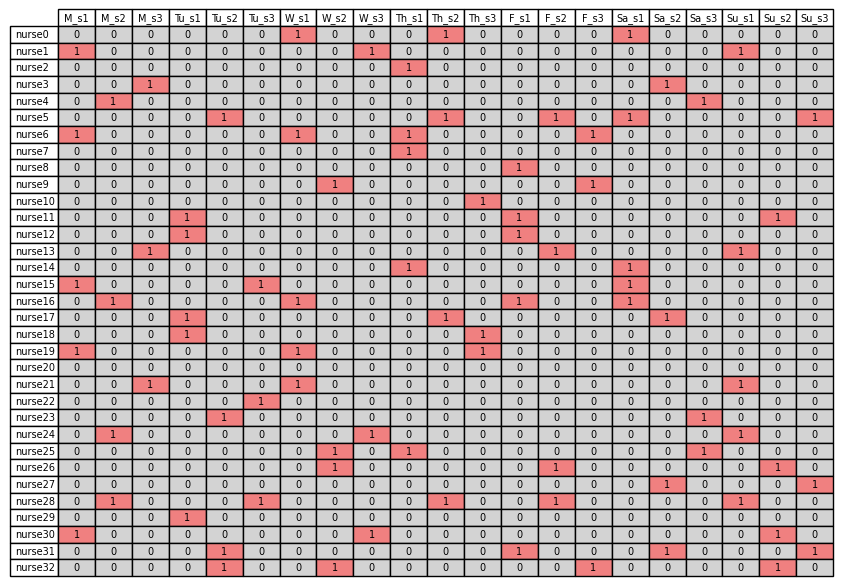

In [43]:
print("The schedule of all nurses: ")
plot_table(schedule, figSize = (10, 4), saveFig = True)

print("The required nurses are: ")
print(r)

In [128]:
def get_nurses_for_shift(shift, table = var):
  d = days.index(shift.split("_")[0])
  shift_index = 3*d + int(shift.split("_s")[1])-1
  nurses = []  
  for n in range(total):
    val = int(value(table[(n, shift_index)]))
    if val == 1: 
      nurses.append(n)
  return nurses


In [164]:
nurses_day1 =  get_nurses_for_shift("M_s1")
nurses_day1

[1, 6, 15, 19, 30]

In [165]:
import random
def generate_patients_data(num_patients, max_treatment_duration):
  duration = []
  for p in range(num_patients):
    duration.append(random.randint(1, max_treatment_duration) * 10)

  return duration

In [163]:
num_patients = 21
treatment_duration = generate_patients_data(num_patients, 6)
treatment_duration

[60,
 20,
 60,
 10,
 30,
 30,
 60,
 10,
 10,
 30,
 30,
 40,
 10,
 50,
 20,
 50,
 60,
 20,
 40,
 40,
 60]

In [166]:
def LpProb_Pacient_Assign():

    # The prob variable is created to contain the problem data   
    prob2 = LpProblem("Pacient Assignment",LpMaximize)
    
    # Creating the variables. 
    for  n in range(len(nurses_day1)):
      print(n)
    var_p_n = {
     (p, n): pulp.LpVariable(
        "assign_{0}_{1}".format(p, n), cat = "Binary")
        for p in range(num_patients) for  n in range(len(nurses_day1))

    }
    print("Cevvaa")
    print(var_p_n)
    # add constraints: 
    # One pacient is treated just by a single nurse in a day

    for p in range(num_patients):
      prob2.addConstraint(
          sum(var_p_n[(p, n)] for n in range(len(nurses_day1))) <= 1
      )

    
      
    # # add constraints:
    for n in range(len(nurses_day1)):
        try:
            prob2.addConstraint(
            sum(var_p_n[(p,n)]* treatment_duration[p]  for p in range(num_patients) ) <= 8*60
            )
        except:
            print("Overtime!!!!")
            sys.exit(-1)   

  

    prob2.objective = sum(var_p_n[(p, n)] for n in range(len(nurses_day1)) for p in range(num_patients))

    return var_p_n, prob2

In [167]:
var_p_n, prob2 = LpProb_Pacient_Assign()
prob2.solve()
print(LpStatus[prob2.status])

0
1
2
3
4
Cevvaa
{(0, 0): assign_0_0, (0, 1): assign_0_1, (0, 2): assign_0_2, (0, 3): assign_0_3, (0, 4): assign_0_4, (1, 0): assign_1_0, (1, 1): assign_1_1, (1, 2): assign_1_2, (1, 3): assign_1_3, (1, 4): assign_1_4, (2, 0): assign_2_0, (2, 1): assign_2_1, (2, 2): assign_2_2, (2, 3): assign_2_3, (2, 4): assign_2_4, (3, 0): assign_3_0, (3, 1): assign_3_1, (3, 2): assign_3_2, (3, 3): assign_3_3, (3, 4): assign_3_4, (4, 0): assign_4_0, (4, 1): assign_4_1, (4, 2): assign_4_2, (4, 3): assign_4_3, (4, 4): assign_4_4, (5, 0): assign_5_0, (5, 1): assign_5_1, (5, 2): assign_5_2, (5, 3): assign_5_3, (5, 4): assign_5_4, (6, 0): assign_6_0, (6, 1): assign_6_1, (6, 2): assign_6_2, (6, 3): assign_6_3, (6, 4): assign_6_4, (7, 0): assign_7_0, (7, 1): assign_7_1, (7, 2): assign_7_2, (7, 3): assign_7_3, (7, 4): assign_7_4, (8, 0): assign_8_0, (8, 1): assign_8_1, (8, 2): assign_8_2, (8, 3): assign_8_3, (8, 4): assign_8_4, (9, 0): assign_9_0, (9, 1): assign_9_1, (9, 2): assign_9_2, (9, 3): assign_9_3, (9

/usr/local/lib/python3.10/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [169]:
from pandas._libs.lib import to_object_array_tuples
def check_pacient_assignment_shift():
    # return True if the constraints have been satisfied otherwise return False

    for p in range(num_patients):
       if sum(value(var_p_n[(p, n)])for n in range(len(nurses_day1))) > 1:
            return False

    for n in range(len(nurses_day1)):
        try:    
           if sum(value(var_p_n[(p,n)]) * treatment_duration[p] for p in range(num_patients)) > 8 * 60:
            return False

        except:
            print("Exception")
            sys.exit(-1)   

    return True

    
print("Check the off_shift constraint: {}".format(check_pacient_assignment_shift()))

Check the off_shift constraint: True


In [ ]:
var_p_n

In [ ]:
num_patients

In [170]:
def patient_scheduling(var_p_n):

    schedule_p = pd.DataFrame(data=None, index = range(num_patients), columns = range(len(nurses_day1)) )
    
    for k, v in var_p_n.items():
        n, s = k[0], k[1]
        schedule_p.iloc[n][s] = int(value(v)) # pulp.value()
        
    return schedule_p
schedule_p = patient_scheduling(var_p_n)

schedule_p

,0,1,2,3,4
0,0,1,0,0,0
1,0,1,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,0,0,0,0,1
6,0,0,1,0,0
7,0,0,0,0,1
8,0,0,1,0,0
9,0,0,0,1,0
